In [4]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scorecardpy as sc
# Add the parent directory to the path
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

In [5]:
# import 
from Scripts.analysis_script import *


df = load_data('../Datas/data.csv')
print(df.head())


         TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871   BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770   BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203   BatchId_53941  AccountId_4229   SubscriptionId_222   
3    TransactionId_380  BatchId_102363   AccountId_648  SubscriptionId_2185   
4  TransactionId_28195   BatchId_38780  AccountId_4841  SubscriptionId_3829   

        CustomerId CurrencyCode  CountryCode    ProviderId     ProductId  \
0  CustomerId_4406          UGX          256  ProviderId_6  ProductId_10   
1  CustomerId_4406          UGX          256  ProviderId_4   ProductId_6   
2  CustomerId_4683          UGX          256  ProviderId_6   ProductId_1   
3   CustomerId_988          UGX          256  ProviderId_1  ProductId_21   
4   CustomerId_988          UGX          256  ProviderId_4   ProductId_6   

      ProductCategory    ChannelId   Amount  Value  TransactionStart

In [6]:
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'], errors='coerce')
current_date = df['TransactionStartTime'].max()

# Aggregate customer metrics
customer_metrics = df.groupby('CustomerId').agg({
    'TransactionStartTime': lambda x: (current_date - x.max()).days,  # Recency
    'TransactionId': 'count',  # Frequency
    'Amount': ['sum', 'mean'],  # Monetary and Size
})

# Flatten MultiIndex columns
customer_metrics.columns = ['Recency', 'Frequency', 'MonetaryTotal', 'MonetaryAvg']

# Normalize the metrics
for col in customer_metrics.columns:
    customer_metrics[f'{col}_Normalized'] = (customer_metrics[col] - customer_metrics[col].min()) / (customer_metrics[col].max() - customer_metrics[col].min())

# Calculate RFMS score (weights can be adjusted as needed)
customer_metrics['RFMS_Score'] = (
    0.25 * (1 - customer_metrics['Recency_Normalized']) +  # Inverse of Recency
    0.25 * customer_metrics['Frequency_Normalized'] +
    0.25 * customer_metrics['MonetaryTotal_Normalized'] +
    0.25 * customer_metrics['MonetaryAvg_Normalized']
)

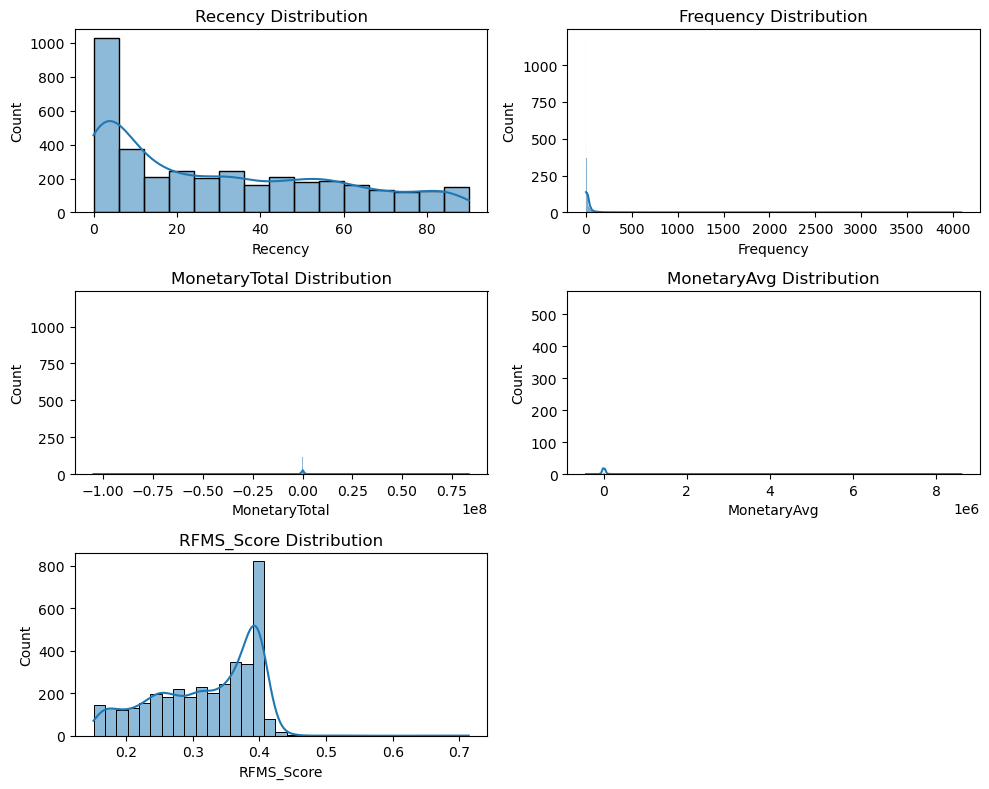

In [7]:
# plt histogram of RFMS metrix



plt.figure(figsize=(10, 8))
metrics = ['Recency', 'Frequency', 'MonetaryTotal', 'MonetaryAvg', 'RFMS_Score']
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    sns.histplot(customer_metrics[metric], kde=True)
    plt.title(f'{metric} Distribution')
    plt.xlabel(metric)
    plt.ylabel('Count')   
plt.tight_layout()
plt.show()

In [8]:
customer_metrics['good_bad'] = np.where(customer_metrics['RFMS_Score'] > 0.4, 'good', 'bad')

# Merge customer_metrics back to the original dataframe (df)
df = df.merge(customer_metrics[['Recency', 'Frequency', 'MonetaryTotal', 'MonetaryAvg', 'RFMS_Score', 'good_bad']], 
              on='CustomerId', how='left')

# Now df will have the RFMS_Score and the 'good_bad' labels
print(df.head())

         TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871   BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770   BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203   BatchId_53941  AccountId_4229   SubscriptionId_222   
3    TransactionId_380  BatchId_102363   AccountId_648  SubscriptionId_2185   
4  TransactionId_28195   BatchId_38780  AccountId_4841  SubscriptionId_3829   

        CustomerId CurrencyCode  CountryCode    ProviderId     ProductId  \
0  CustomerId_4406          UGX          256  ProviderId_6  ProductId_10   
1  CustomerId_4406          UGX          256  ProviderId_4   ProductId_6   
2  CustomerId_4683          UGX          256  ProviderId_6   ProductId_1   
3   CustomerId_988          UGX          256  ProviderId_1  ProductId_21   
4   CustomerId_988          UGX          256  ProviderId_4   ProductId_6   

      ProductCategory  ...  Value      TransactionStartTime  Pricing

In [ ]:
# perfom WoE binning on the features and target

# Select features for WoE binning (excluding the target column 'FraudResult')
X = df.drop('FraudResult', axis=1)
y = 'FraudResult'  # y is just the column name, not the actual data

# Perform WoE binning on the features and target
features_for_woe = X.columns.tolist()  # Get all feature column names as a list

# Perform WoE binning
bins = sc.woebin(df, y=y, x=features_for_woe)

# Apply WoE transformation to the dataframe
woe_df = sc.woebin_ply(df, bins)

# Calculate Information Value (IV) for each feature
iv_values = {}
for feature in features_for_woe:
    iv_values[feature] = bins[feature]['total_iv'].values[0]
    print(f"IV for {feature}: {iv_values[feature]}")


[INFO] creating woe binning ...


c:\Users\Tsega KisPay\AppData\Local\anaconda3\Lib\site-packages\scorecardpy\condition_fun.py:34: UserWarning: There are 2 columns have only one unique values, which are removed from input dataset. 
 (ColumnNames: CurrencyCode, CountryCode)
  warnings.warn("There are {} columns have only one unique values, which are removed from input dataset. \n (ColumnNames: {})".format(len(unique1_cols), ', '.join(unique1_cols)))
c:\Users\Tsega KisPay\AppData\Local\anaconda3\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
c:\Users\Tsega KisPay\AppData\Local\anaconda3\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in

>>> There are 6 variables have too many unique non-numberic values, which might cause the binning process slow. Please double check the following variables: 
TransactionId, BatchId, AccountId, SubscriptionId, CustomerId, TransactionStartTime
>>> Continue the binning process?
1: yes 
2: no


c:\Users\Tsega KisPay\AppData\Local\anaconda3\Lib\site-packages\scorecardpy\condition_fun.py:177: UserWarning: Incorrect inputs; there are 2 x variables are not exist in input data, which are removed from x. 
(CurrencyCode, CountryCode)
  warnings.warn("Incorrect inputs; there are {} x variables are not exist in input data, which are removed from x. \n({})".format(len(x_notin_xall), ', '.join(x_notin_xall)))
c:\Users\Tsega KisPay\AppData\Local\anaconda3\Lib\site-packages\scorecardpy\woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  init_bin = dtm.groupby('bin', group_keys=False)['y'].agg([n0, n1])\
c:\Users\Tsega KisPay\AppData\Local\anaconda3\Lib\site-packages\scorecardpy\woebin.py:361: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. I

In [ ]:
# plot WoE binning result for a feature

if i in bins:
    plt.figure(figsize=(10, 6))
    sc.woebin_plot(bins[i])
    plt.title('WoE Binning Plot for')
    plt.tight_layout()
    plt.show()
else:
    print(f"Feature {i} not found in WoE bins. Available features are:")
    print(bins.keys())

NameError: name 'bins' is not defined